In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy.matlib

In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, evd

In [4]:
train_test_str = 'train_test'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [5]:
# output file prefix
outfile_prefix = exclude_str+'_'+parc_str+'_'+str(parc_scale)+'_'
outfile_prefix

't1Exclude_schaefer_400_'

### Setup directory variables

In [6]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)
    
# storedir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction', 'store')
storedir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction_fixedpcs', 'store')
print(storedir)
if not os.path.exists(storedir): os.makedirs(storedir)
    
# outputdir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction', 'out')
outputdir = os.path.join(os.environ['PIPELINEDIR'], '8_prediction_fixedpcs', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output_nosibs/figs
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline_nosibs/8_prediction_fixedpcs/store
/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline_nosibs/8_prediction_fixedpcs/out


## Setup plots

In [7]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']

metrics = ['ct', 'vol']
metrics_label_short = ['Thickness', 'Volume']
metrics_label = ['Thickness', 'Volume']

## Load data

In [8]:
# Test
df_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'test.csv'))
df_test.set_index(['bblid', 'scanid'], inplace = True)
df_node_test = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '2_prepare_normative', 'out', outfile_prefix+'resp_test.csv'))
df_node_test.set_index(['bblid', 'scanid'], inplace = True)

## Load nispat outputs

In [9]:
z = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '4_run_normative', outfile_prefix+'out', 'Z.txt'), delimiter = ' ').transpose()
df_z_test = pd.DataFrame(data = z, index = df_node_test.index, columns = df_node_test.columns)

### Calculate mean raw features

In [10]:
df_node_mean = pd.DataFrame(index = df_node_test.index)
for metric in metrics:
    df_node_mean[metric] = df_node_test.filter(regex = metric).mean(axis = 1)

### Calculate mean deviations

In [11]:
df_node_z_mean = pd.DataFrame(index = df_z_test.index)
for metric in metrics:
    df_node_z_mean[metric] = df_z_test.filter(regex = metric).mean(axis = 1)

### Calculate EVD

In [12]:
# extreme value summary (cf. Marquand et al. Biological Psyciatry)
signs = ['neg', 'pos', 'abs']
df_z_evd = pd.DataFrame(index = df_z_test.index)
evd_thr = 0.1
for metric in metrics:
    for sign in signs:
        df_z_evd[metric+'_'+sign] = evd(df_z_test.filter(regex = metric), thr = evd_thr, sign = sign)

## Save out

In [13]:
# export for prediction models
df_node_test.to_csv(os.path.join(storedir, outfile_prefix+'X.csv'))
df_z_test.to_csv(os.path.join(storedir, outfile_prefix+'X_z.csv'))

df_node_mean.to_csv(os.path.join(storedir, outfile_prefix+'X_mean.csv'))
df_node_z_mean.to_csv(os.path.join(storedir, outfile_prefix+'X_z_mean.csv'))
df_z_evd.to_csv(os.path.join(storedir, outfile_prefix+'X_z_evd.csv'))

df_test.loc[:,phenos].to_csv(os.path.join(storedir, outfile_prefix+'y.csv'))

covs = ['ageAtScan1_Years', 'sex_adj']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

covs = ['ageAtScan1_Years', 'sex_adj', 'medu1']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

covs = ['ageAtScan1_Years', 'sex_adj', 'averageManualRating']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

covs = ['ageAtScan1_Years', 'sex_adj', 'T1_snr']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

covs = ['ageAtScan1_Years', 'sex_adj', 'wrat4CrRaw']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

covs = ['ageAtScan1_Years', 'sex_adj', 'mprage_antsCT_vol_TBV']
df_test.loc[:,covs].to_csv(os.path.join(storedir, outfile_prefix+'c_'+'_'.join(covs)+'.csv'))

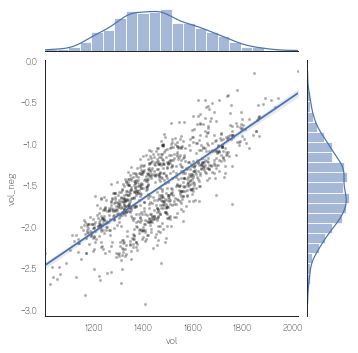

In [14]:
metric = metrics[1]
sign = signs[0]
f = sns.jointplot(x = df_node_mean.loc[:,metric], y = df_z_evd.loc[:,metric+'_'+sign], kind='reg', height=5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

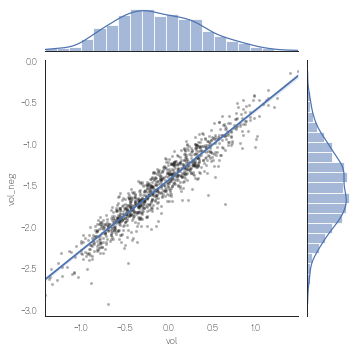

In [15]:
metric = metrics[1]
sign = signs[0]
f = sns.jointplot(x = df_node_z_mean.loc[:,metric], y = df_z_evd.loc[:,metric+'_'+sign], kind='reg', height=5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

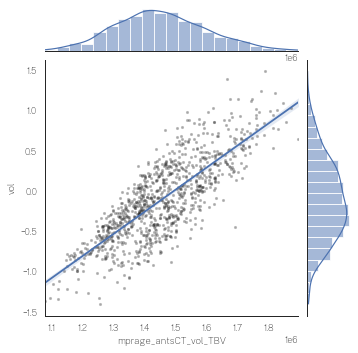

In [16]:
metric = metrics[1]
sign = signs[0]
covs = ['ageAtScan1_Years', 'sex_adj', 'mprage_antsCT_vol_TBV', 'medu1', 'averageManualRating']
f = sns.jointplot(x = df_test.loc[:,covs[2]], y = df_node_z_mean.loc[:,metric], kind='reg', height=5)
# f = sns.jointplot(x = df_test.loc[:,covs[2]], y = df_node_mean.loc[:,metric], kind='reg', height=5)
# f = sns.jointplot(x = df_test.loc[:,covs[2]], y = df_z_evd.loc[:,metric+'_'+sign], kind='reg', height=5)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

### Examine dimensionality reduction

[25.04  2.    1.83  1.46  1.35  1.24  1.18  1.14  1.04]
vol 9 0.3627495274163392
[31.83  1.97  1.6   1.38  1.24  1.17  1.13  1.06  0.94]
vol 8 0.41385151636504136


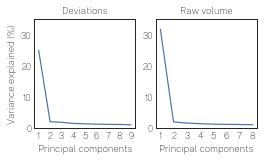

In [17]:
sns.set(style='white', context = 'paper', font_scale = 1)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Public Sans']})

f, ax = plt.subplots(1,2)
f.set_figwidth(4)
f.set_figheight(2)

N_components = []
metric = metrics[1]
for i in np.arange(2):
    if i == 0:
        x = df_z_test.filter(regex = metric)
    elif i == 1:   
        x = df_node_test.filter(regex = metric)

    # find number of PCs that explain 80% variance
    pca = PCA(n_components = x.shape[1], svd_solver = 'full')
    pca.fit(StandardScaler().fit_transform(x))
    var_idx = pca.explained_variance_ratio_ >= .01
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.sum(var_idx)
#     n_components = np.where(cum_var >= 0.8)[0][0]+1
    var_exp = cum_var[n_components-1]
    print(np.round(pca.explained_variance_ratio_[:9]*100,2))

    N_components.append(n_components)
    
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n_components, svd_solver='full', random_state = 0)
    pca.fit(x)

    ax[i].plot(pca.explained_variance_ratio_*100)
    ax[i].set_xlabel('Principal components')
    ax[i].set_xticks(np.arange(0,len(pca.explained_variance_ratio_)))
    ax[i].set_xticklabels(np.arange(1,len(pca.explained_variance_ratio_)+1))
    if i == 0:
        ax[i].set_ylabel('Variance explained (%)')
    if i == 0: ax[i].set_title('Deviations')
    elif i == 1: ax[i].set_title('Raw volume')
        
    ax[i].tick_params(pad = -2)
    ax[i].set_ylim([0,0.35*100])

    print(metric, n_components, np.sum(pca.explained_variance_ratio_))
    
f.savefig(outfile_prefix+'pca_scree.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Plot coefficients

In [18]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

Notebook initialized with png backend.


In [19]:
if parc_str == 'schaefer':
    subject_id = 'fsaverage'
elif parc_str == 'lausanne':
    subject_id = 'lausanne125'

In [20]:
figs_to_delete = []
metric = metrics[1]; print(metric)

i=1
if i == 0:
    x = df_z_test.filter(regex = metric)
elif i == 1:   
    x = df_node_test.filter(regex = metric)

x = StandardScaler().fit_transform(x)
n_components=9
pca = PCA(n_components=n_components, svd_solver='full', random_state = 0)
pca.fit(x)

for pc in np.arange(0,n_components):
    roi_data = pca.components_[pc,:]
    for hemi in ('lh', 'rh'):
        fig_str = hemi + '_' + metric + '_pc_' + str(pc)
        figs_to_delete.append('ventral_'+fig_str)
        figs_to_delete.append('med_'+fig_str)
        figs_to_delete.append('lat_'+fig_str)

        if subject_id == 'lausanne125':
            parc_file = os.path.join('/Applications/freesurfer/subjects/', subject_id, 'label', hemi + '.myaparc_' + str(parc_scale) + '.annot')
        elif subject_id == 'fsaverage':
            parc_file = os.path.join('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                     hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

        # project subject's data to vertices
        brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi, surf = 'inflated', showcolorbar = False)

vol
0.06515052277264619
0.0691863801113599
0.20112850938645646
0.20313347529099066
0.16177118901262189
0.14555770796353645
0.12399389137216602
0.11767480744849806
0.1447915228592791
0.14672571232580783
0.1951159694963197
0.1680385864775793
0.13432388214923408
0.17188558735814657
0.14812249269629374
0.13698848584585532
0.17327527219479874
0.18507536972983227


vol 0


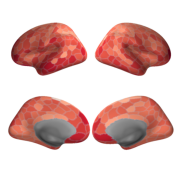

vol 1


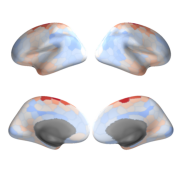

vol 2


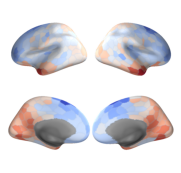

vol 3


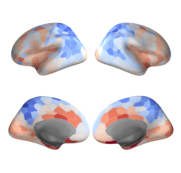

vol 4


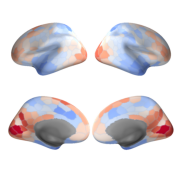

vol 5


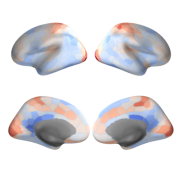

vol 6


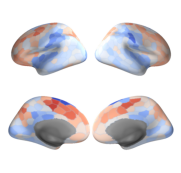

vol 7


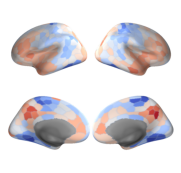

vol 8


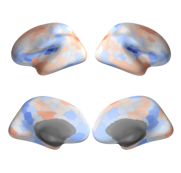

In [21]:
for pc in np.arange(0,n_components):
    f, axes = plt.subplots(2, 2)
    f.set_figwidth(3)
    f.set_figheight(4)
    plt.subplots_adjust(wspace=0, hspace=-0.465)

    print(metric, pc)
    # column 0:
    fig_str = 'lh_'+metric+'_pc_'+str(pc)+'.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
    except FileNotFoundError: axes[0,0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
    except FileNotFoundError: axes[1,0].axis('off')


    # column 1:
    fig_str = 'rh_'+metric+'_pc_'+str(pc)+'.png'
    try:
        image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
    except FileNotFoundError: axes[0,1].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
    except FileNotFoundError: axes[1,1].axis('off')

    plt.show()
    if i == 0:
        f.savefig(outfile_prefix+metric+'_z_pc_'+str(pc)+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)
    elif i == 1:   
        f.savefig(outfile_prefix+metric+'_raw_pc_'+str(pc)+'.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [22]:
for file in figs_to_delete:
    try:
        os.remove(os.path.join(figdir,file+'.png'))
    except:
        print(file, 'not found')